# RoBERTa
Use RoBERTa Model with pretrained RoBERTa tokenizer from huggingface.

## Import Packages and Environment Variables

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm.auto as tqdm
import transformers
from sklearn.model_selection import train_test_split
import os

In [2]:
DATA_PATH = "data/"
DIR_PATH = os.getcwd()
TRAIN_DATA_PATH = os.path.join(DIR_PATH, DATA_PATH, "train.csv")
TEST_DATA_PATH = os.path.join(DIR_PATH, DATA_PATH, "test.csv")

VALIDATION_RATIO = 0.05
SEED = 1234

REMOVE_DUPLICATE = False
TRANSFORMER_NAME = "roberta-base"

BATCH_SIZE = 16
LEARNING_RATE = 1e-5
EPOCHS = 5

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

Using device: cuda:0


In [4]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
tqdm.tqdm.pandas()# enable progress_apply and progress_mapfor pandas

## Data Preprocessed and Feature Engineering

In [6]:
train_data = pd.read_csv(TRAIN_DATA_PATH)
test = pd.read_csv(TEST_DATA_PATH)
train_data.head()

,review,sentiment
0,the single worst film i've ever seen in a thea...,negative
1,I was actually around 13 years old camping nea...,positive
2,A small town is attacked by a horde of bloodth...,negative
3,I think the problem with this show not getting...,positive
4,"Wow, this movie was horrible. As a Bills fan I...",negative


In [7]:
test.head()

,id,review
0,0,An expedition party made up of constantly bick...
1,1,"Well, I'll be honest: It is not exactly a Shol..."
2,2,"This is not a boring movie, the audience might..."
3,3,My boyfriend and I decided to go see this movi...
4,4,It's a shame this movie is rated PG 13--it is ...


In [8]:
# Remove Duplicated Data
if REMOVE_DUPLICATE:
    print(train_data.duplicated(subset=["review"]).sum())
    train_data.drop_duplicates(subset=["review"], inplace=True)
    train_data = train_data.reset_index(drop=True)

In [9]:
train_data["sentiment"] = train_data["sentiment"].progress_map(
    lambda x:1 if x == "positive" else 0
    )
train_data.head()

  0%|          | 0/40000 [00:00<?, ?it/s]

,review,sentiment
0,the single worst film i've ever seen in a thea...,0
1,I was actually around 13 years old camping nea...,1
2,A small town is attacked by a horde of bloodth...,0
3,I think the problem with this show not getting...,1
4,"Wow, this movie was horrible. As a Bills fan I...",0


In [ ]:
# Tockenizer
tokenizer = transformers.RobertaTokenizer.from_pretrained(TRANSFORMER_NAME)

def tokenize_function(examples, tokenizer):
    return tokenizer(examples, truncation=True)["input_ids"] 

In [ ]:
train_data["input_ids"] = train_data["review"].progress_map(lambda x :tokenize_function(x, tokenizer=tokenizer))
test["input_ids"] = test["review"].progress_map(lambda x :tokenize_function(x, tokenizer=tokenizer))    

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
train_data.head()

,review,sentiment,input_ids
0,the single worst film i've ever seen in a thea...,0,"[101, 1996, 2309, 5409, 2143, 1045, 1005, 2310..."
1,I was actually around 13 years old camping nea...,1,"[101, 1045, 2001, 2941, 2105, 2410, 2086, 2214..."
2,A small town is attacked by a horde of bloodth...,0,"[101, 1037, 2235, 2237, 2003, 4457, 2011, 1037..."
3,I think the problem with this show not getting...,1,"[101, 1045, 2228, 1996, 3291, 2007, 2023, 2265..."
4,"Wow, this movie was horrible. As a Bills fan I...",0,"[101, 10166, 1010, 2023, 3185, 2001, 9202, 101..."


In [ ]:
test.head()

,id,review,input_ids
0,0,An expedition party made up of constantly bick...,"[101, 2019, 5590, 2283, 2081, 2039, 1997, 7887..."
1,1,"Well, I'll be honest: It is not exactly a Shol...","[101, 2092, 1010, 1045, 1005, 2222, 2022, 7481..."
2,2,"This is not a boring movie, the audience might...","[101, 2023, 2003, 2025, 1037, 11771, 3185, 101..."
3,3,My boyfriend and I decided to go see this movi...,"[101, 2026, 6898, 1998, 1045, 2787, 2000, 2175..."
4,4,It's a shame this movie is rated PG 13--it is ...,"[101, 2009, 1005, 1055, 1037, 9467, 2023, 3185..."


In [ ]:
tokenizer.pad_token # Padding token

'[PAD]'

In [ ]:
tokenizer.pad_token_id # Padding token id

0

In [ ]:
# Use this index as padding value
pad_index = tokenizer.pad_token_id 

## Split trainning  set and validation set

In [ ]:
train_data, valid_data = train_test_split(train_data, 
                                          test_size=VALIDATION_RATIO,
                                          random_state=SEED)
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

In [ ]:
train_data.size, valid_data.size

(114000, 6000)

In [ ]:
train_data.head()

,review,sentiment,input_ids
0,What an empty and lack lustre rendition of the...,0,"[101, 2054, 2019, 4064, 1998, 3768, 11516, 289..."
1,"Bad plot (though good for a B-movie), good fas...",0,"[101, 2919, 5436, 1006, 2295, 2204, 2005, 1037..."
2,This is one of the worst movies ever made. Tri...,0,"[101, 2023, 2003, 2028, 1997, 1996, 5409, 5691..."
3,This series was a cut above the rest of the TV...,1,"[101, 2023, 2186, 2001, 1037, 3013, 2682, 1996..."
4,You can only describe this with one word and t...,0,"[101, 2017, 2064, 2069, 6235, 2023, 2007, 2028..."


## Dataset & DataLoader

In [ ]:
class dataset(Dataset):
    """
    Custom dataset
    Args:
        data (pd.DataFrame): DataFrame containing 'input_ids' and 'sentiment' columns.
    """
    def __init__(self, data:pd.DataFrame):
        super().__init__()
        self.ids = data["input_ids"].to_list()
        self.labels = data["sentiment"].to_list()
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, ind):
        ids_tensor = torch.tensor(self.ids[ind], dtype=torch.int64)

        labels_tensor = torch.tensor(self.labels[ind], dtype=torch.int64)
        return {"ids" : ids_tensor, "label" : labels_tensor}

### Make custon collate function for padding
Since the review length is different, we need to pad the input_ids to the same length in a batch.

In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

### Create DataLoader

In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=True):
    """Get DataLoader with custom collate_fn for padding."""
    collate_fn = get_collate_fn(pad_index)
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    )
    return data_loader

In [ ]:
train_dataset = dataset(train_data)
valid_dataset = dataset(valid_data)

train_loader = get_data_loader(train_dataset, BATCH_SIZE, 
                               pad_index, shuffle=True)
valid_loader = get_data_loader(valid_dataset, BATCH_SIZE, 
                               pad_index, shuffle=False) 


## Model 
Build and Fine-tune the pre-trained model.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, transformer_name, num_classes, freeze):
        super().__init__()
        self.transformer = transformers.RobertaModel.from_pretrained(transformer_name)
        self.classifier = nn.Linear(self.transformer.config.hidden_size,
                                    num_classes)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, input_ids):
        outputs = self.transformer(input_ids=input_ids).last_hidden_state
        cls_output = outputs[:, 0, :]  # [CLS] token output
        logits = self.classifier(torch.tanh(cls_output))
        return logits

In [ ]:
output_dim = len(train_data["sentiment"].unique())

In [ ]:
model = Transformer(TRANSFORMER_NAME, output_dim, freeze=False)

## Trainning and Testing

### Trainning Setup

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
model = model.to(DEVICE)

## Trainning, Evaluating and Computing Accuracy

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


In [ ]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
best_valid_loss = float("inf")

metrics = {"train_losses": [],
           "train_accs": [],
           "valid_losses": [],
           "valid_accs": []}

for epoch in range(EPOCHS):
    train_loss, train_acc = train(
        train_loader, model, criterion, optimizer, DEVICE
    )
    valid_loss, valid_acc = evaluate(valid_loader, model, criterion, DEVICE)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

training...:   0%|          | 0/2375 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


### Plot

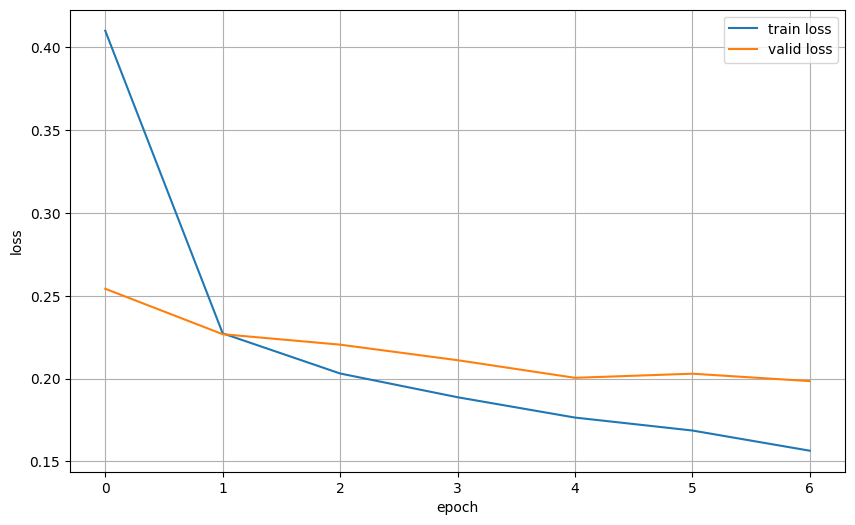

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(EPOCHS))
ax.legend()
ax.grid()

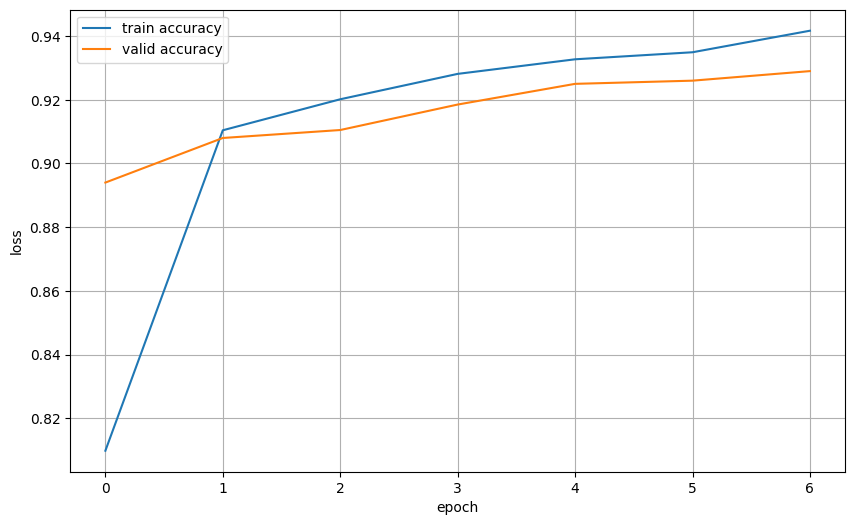

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(EPOCHS))
ax.legend()
ax.grid()

## Generate the test answer

In [ ]:
class testDataset(Dataset):
    def __init__(self, data:pd.DataFrame):
        super().__init__()
        self.ids = data["input_ids"].to_list()
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, ind):
        ids_tensor = torch.tensor(self.ids[ind], dtype=torch.int64)
        return ids_tensor

In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch = {"ids": batch_ids}
        return batch

    return collate_fn

In [ ]:
def predict(data_loader, model, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="predicting..."):
            ids = batch["ids"].to(device)
            prediction = model(ids)
            preds.append(prediction)
    return torch.cat(preds)

In [ ]:
# load the best model
model.load_state_dict(torch.load("transformer.pt"))
model = model.to(DEVICE)
test_dataset = testDataset(test)
test_loader = get_data_loader(test_dataset, BATCH_SIZE, 
                               pad_index, shuffle=False)
predictions = predict(test_loader, model, DEVICE)

predicting...:   0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
prediction_classes = predictions.argmax(dim=-1)
answer = pd.DataFrame({"id" : test["id"],
                       "sentiment": ["positive" if i == 1 else "negative" for i in prediction_classes.cpu().numpy()]})
answer.to_csv("submission.csv", index=False)